In [2]:
import numpy as np
import pickle

import tensorflow as tf
assert tf.__version__[0:6]=='1.15.2', 'Please install tensorflow 1.15.2'
import keras
assert keras.__version__[0:5]=='2.3.1', 'Please install keras 2.3.1'
import h5py
assert h5py.__version__[0:6]=='2.10.0', 'Please install h5py 2.10.0'
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'

# Datasets and Models Loading

In [3]:
#Dataset Import
from keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

cifar_x_data = pickle.load(open('./data/Images/test_set_cifar_cnn_simple.p','rb'))
cifar_y_data = pickle.load(open('./data/Images/test_label_cifar_cnn_simple.p','rb'))
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imagenet_x_data = pickle.load(open('./data/Images/imagenet50.p','rb'))
imagenet_y_data = pickle.load(open('./data/Images/imagenet50_labels.p','rb'))
imagenet_map = pickle.load(open('./data/Images/imagenet_mapping_labels.p','rb'))

In [4]:
#Dataset Shapes
print('MNIST Data Shape')
print(MNIST_x_data_test.shape)
print(MNIST_y_data_test.shape)
print()
print('cifar Data Shape')
print(cifar_x_data.shape)
print(cifar_y_data.shape)
print()
print('imagenet Data Shape')
print(imagenet_x_data.shape)

MNIST Data Shape
(10000, 28, 28)
(10000,)

cifar Data Shape
(10000, 32, 32, 3)
(10000,)

imagenet Data Shape
(50, 224, 224, 3)


In [5]:
#Function to select the model to analyse, unfortunately we had to use tensorflow 1 version to mantain the compatibility among XAI methods and libraries.
#This led to the problem that we need to only have one model at time loaded into the kernel in order to obtain the gradients of only that model
#Run this function every time you want to change dataset and model

def load_data(dataset_name, printing_example=False):
    K.clear_session()
    if dataset_name == 'mnist':
        MNIST_CNN = keras.models.load_model("./models/Images/cnn_simple_mnist_no_pickle")
        if printing_example:
            MNIST_CNN.summary()
            print('MNIST Prediction Example')
            plt.imshow(MNIST_x_data_test[0,:].reshape(28,28), cmap='gray')
            print('Prediction: ',np.where(MNIST_CNN.predict(MNIST_x_data_test[0,:].reshape(1,28,28,1))==1)[1])
        return MNIST_CNN
        
    elif dataset_name == 'cifar':
        cifar_CNN = keras.models.load_model('./models/Images/cnn_simple_cifar_no_pickle')
        if printing_example:
            cifar_CNN.summary()
            print('cifar Prediction Example')
            plt.imshow(cifar_x_data[16,:,:,:])
            print('Prediction: ',cifar_labels[int(np.argmax(cifar_CNN.predict(cifar_x_data[16:17,:,:,:]),axis=1))])
        return cifar_CNN
        
    elif dataset_name == 'imagenet':
        imagenet_VGG = keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
        #y_hat = np.argmax(imagenet_VGG.predict(imagenet_x_data),axis=1)
        if printing_example:
            imagenet_VGG.summary()
            print('imagenet Prediction Example')
            plt.imshow(imagenet_x_data[3,:]/255)
            print('Prediction: ', imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[3:4,:]).ravel()))][1])
        return imagenet_VGG
        
    else:
        raise Exception('Model name not recognized')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_____________________________________

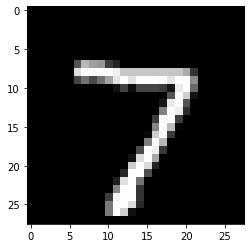

In [6]:
load_data('mnist',True);

# Saliency Maps Methods

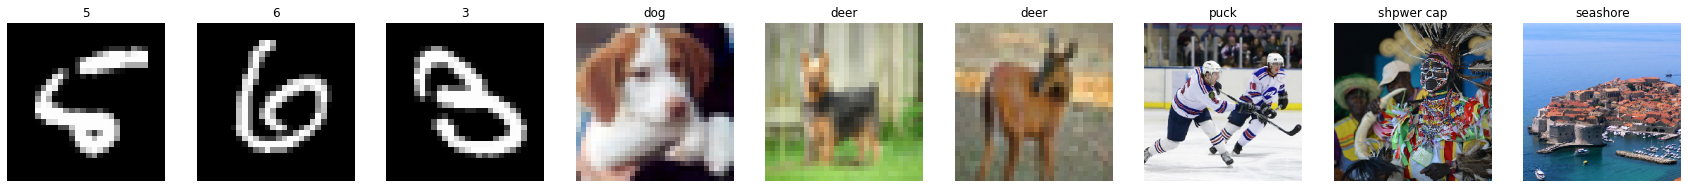

In [9]:
# Images used in the paper as examples
MNIST_test_idx = [8,11,18]
MNIST_y_hat = [5,6,3]
CIFAR_test_idx = [16,24,36]
CIFAR_y_hat = [5,4,4]
IMAGENET_test_idx = [3,7,9]
IMAGENET_y_hat = [746,793,978]
F,ax = plt.subplots(1,9,figsize=(30,3))

for i in range(9):
    ax[i].axis('off')

ax[0].imshow(MNIST_x_data_test[8:9,:].squeeze(0),cmap='gray')
ax[0].set_title('5')
ax[1].imshow(MNIST_x_data_test[11:12,:].squeeze(0),cmap='gray')
ax[1].set_title('6')
ax[2].imshow(MNIST_x_data_test[18:19,:].squeeze(0),cmap='gray')
ax[2].set_title('3')
ax[3].imshow(cifar_x_data[16:17,:].squeeze(0),cmap='gray')
ax[3].set_title('dog')
ax[4].imshow(cifar_x_data[24:25,:].squeeze(0),cmap='gray')
ax[4].set_title('deer')
ax[5].imshow(cifar_x_data[36:37,:].squeeze(0),cmap='gray')
ax[5].set_title('deer')
ax[6].imshow(imagenet_x_data[3:4,:].astype(int).squeeze(0))
ax[6].set_title('puck')
ax[7].imshow(imagenet_x_data[7:8,:].astype(int).squeeze(0))
ax[7].set_title('shpwer cap')
ax[8].imshow(imagenet_x_data[9:10,:].astype(int).squeeze(0))
ax[8].set_title('seashore');

## IntGrad

In [8]:
#import intgrad algorithm
from scripts.images.intgrad import *
import time

# plot function of intgrad values
def plot_img_attributions(model,
                          baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    if len(image.shape)==2:
        image = image[:,:,np.newaxis]
    image_tensor = tf.convert_to_tensor(image)
    attributions = integrated_gradients(model,
                                        baseline=baseline,
                                        image=tf.cast(tf.reshape(image_tensor,image.shape),tf.float32),
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)
    
    start = time.time()
    output = K.get_session().run(attributions, feed_dict={image_tensor:image})

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = np.sum(np.abs(output), axis=-1)

    print('time: ',time.time()-start)

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(10, 5))
    
    axs[0, 0].set_title('Example')
    axs[0, 0].imshow(image,cmap='gray')
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Attribution mask')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].axis('off')

    axs[0, 2].set_title('Overlay')
    axs[0, 2].imshow(attribution_mask, cmap=cmap)
    axs[0, 2].imshow(image,cmap='gray',alpha=overlay_alpha)
    axs[0, 2].axis('off')

    plt.tight_layout()
    return fig

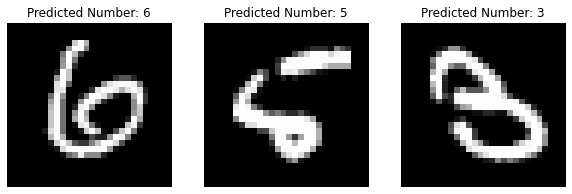

In [9]:
MNIST_CNN = load_data('mnist')
# Print the images we want to explain
img = [8,11,18]
F,ax=plt.subplots(1,len(img),figsize=(10,5))
ax = ax.ravel()

for i in range(len(img)):
    ax[i].set_title('Predicted Number: '+str(int(np.argmax(MNIST_CNN.predict(MNIST_x_data_test[img[i]:img[i]+1,:].reshape(1,28,28,1)/255)))))
    ax[i].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    ax[i].axis('off')


time:  0.3827090263366699
time:  0.3628528118133545
time:  0.3505868911743164


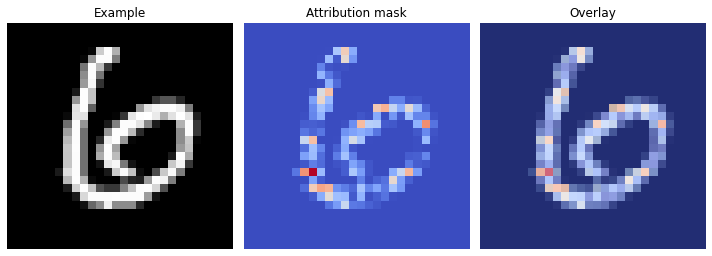

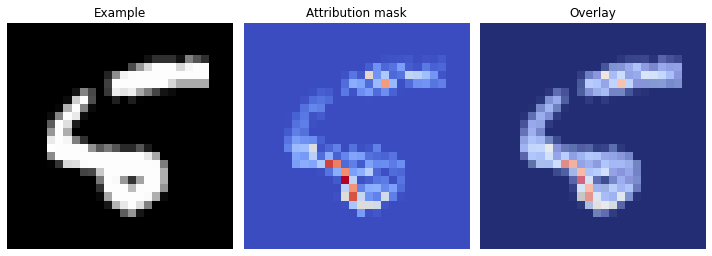

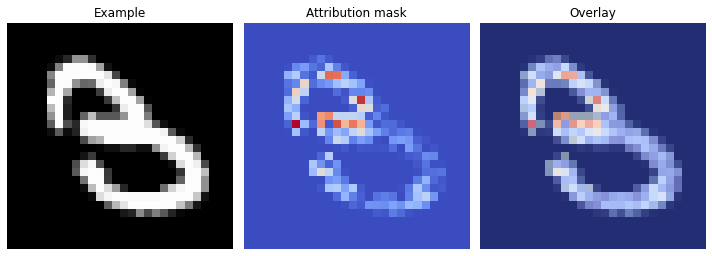

In [10]:
baseline = tf.zeros(shape=(28,28,1))

for idx in img:
    image = MNIST_x_data_test[idx,:]
    target = int(np.where(MNIST_CNN.predict(MNIST_x_data_test[img[i]:img[i]+1,:].reshape(1,28,28,1)))[1])

    F = plot_img_attributions(model=MNIST_CNN,
                            image=image,
                            baseline=baseline,
                            target_class_idx=target,
                            m_steps=240,
                            cmap=plt.cm.coolwarm,
                            overlay_alpha=0.4)

    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/MNIST_{idx}_coolwarm.png')
    #plt.close()

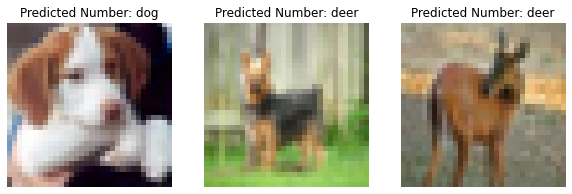

In [11]:
cifar_CNN = load_data('cifar')
# Print the images we want to explain
img = [16,24,36]
F,ax=plt.subplots(1,len(img),figsize=(10,5))
ax = ax.ravel()

for i in range(len(img)):
    ax[i].set_title('Predicted Number: '+str(cifar_labels[int(np.argmax(cifar_CNN.predict(cifar_x_data[img[i]:img[i]+1,:])))]))
    ax[i].imshow(cifar_x_data[img[i],:],cmap='gray')
    ax[i].axis('off')

time:  0.7049262523651123
time:  0.7536451816558838
time:  0.8188221454620361


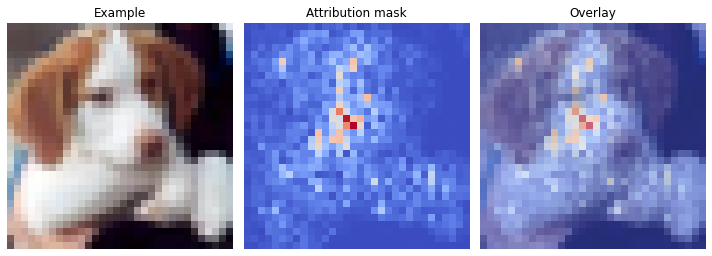

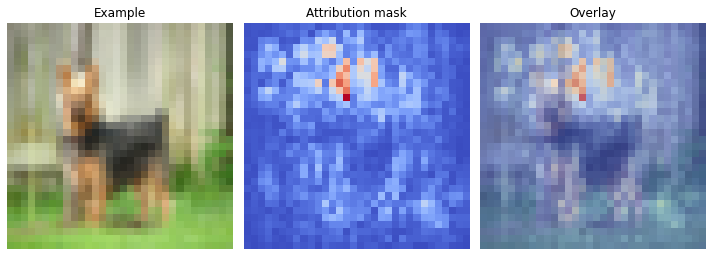

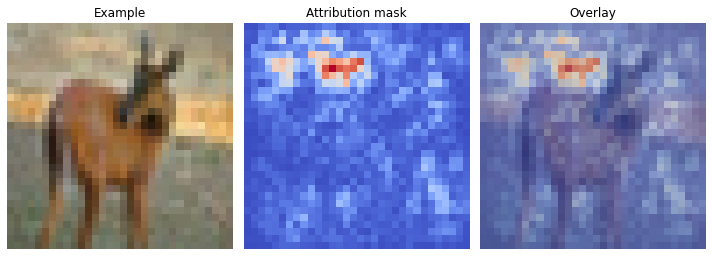

In [12]:
for idx in img:
    baseline = tf.zeros(shape=(32,32,3))

    image = cifar_x_data[idx,:,:,:]
    target = int(np.argmax(cifar_CNN.predict(cifar_x_data[idx:idx+1,:,:,:]),axis=1)[0])

    F = plot_img_attributions(model=cifar_CNN,
                            image=image,
                            baseline=baseline,
                            target_class_idx=target,
                            m_steps=240,
                            cmap=plt.cm.coolwarm,
                            overlay_alpha=0.4)
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/cifar_{idx}.png')
    #plt.close()

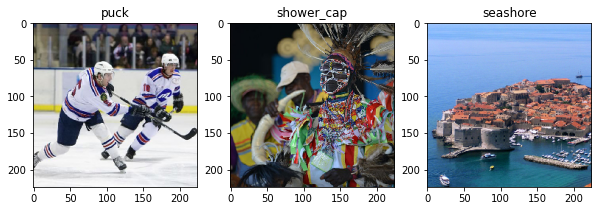

In [12]:
imagenet_VGG = load_data('imagenet')
img = [3,7,9]
F,ax=plt.subplots(1,len(img),figsize=(10,5))
ax = ax.ravel()

for i in range(len(img)):
    ax[i].set_title(imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[img[i]:img[i]+1,:]).ravel()))][1])
    ax[i].imshow(imagenet_x_data[img[i],:].astype(int))

time:  14.162474870681763
time:  14.636559247970581
time:  15.188566207885742


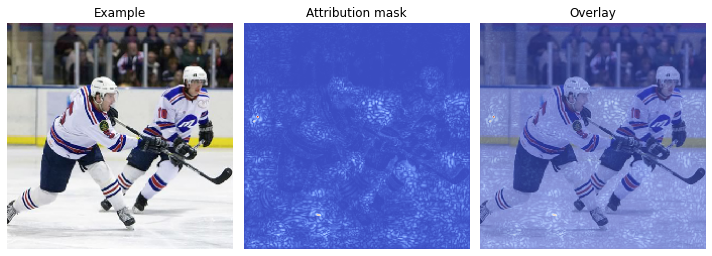

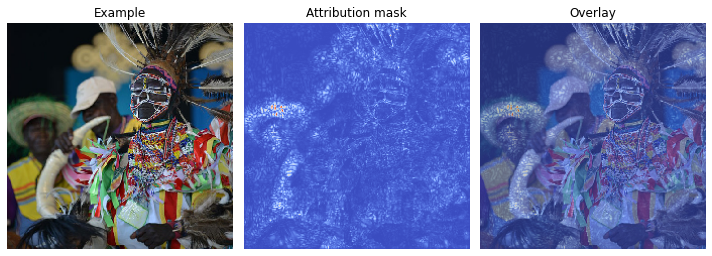

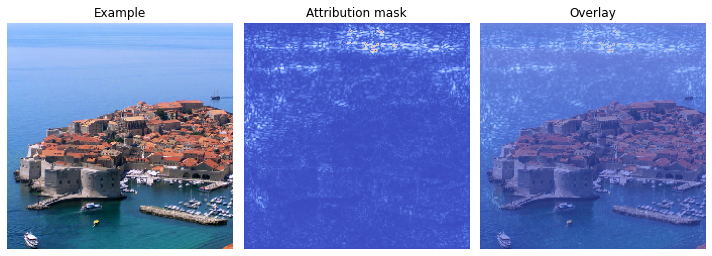

In [15]:
for idx in img:
    baseline = tf.zeros(shape=(224,224,3))

    image = imagenet_x_data[idx,:,:,:].astype(int)
    target = int(np.argmax(imagenet_VGG.predict(imagenet_x_data[idx:idx+1,:]).ravel()))

    F = plot_img_attributions(model=imagenet_VGG,
                              image=image,
                              baseline=baseline,
                              target_class_idx=target,
                              m_steps=50,
                              cmap=plt.cm.coolwarm,
                              overlay_alpha=0.4)

    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/imagenet_{idx}.png')
    #plt.close()

## DeepLift

In [14]:
#Taken from https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
from scripts.images.deepexplain import DeepExplain
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

In [15]:
from skimage import feature, transform

def saliency_plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, use_quantiles=False):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        if use_quantiles:
            edges = feature.canny(in_image_upscaled,use_quantiles=True,high_threshold=0.9).astype(float)
        else: 
            edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

0.11885786056518555
0.17360997200012207
0.22984075546264648


/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


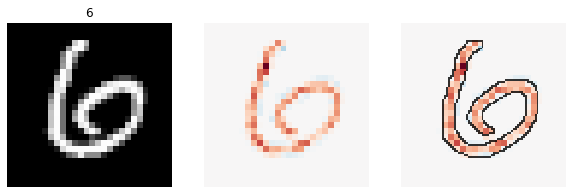

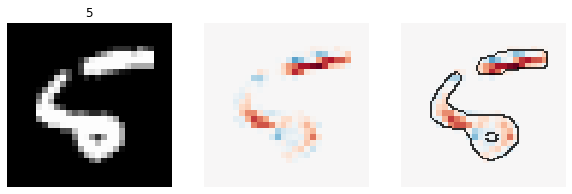

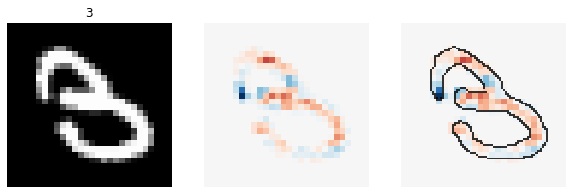

In [19]:
# ----- MNIST -----
MNIST_CNN = load_data('mnist')

new_layer = Dense(10,name='new_dense')
inp = MNIST_CNN.layers[0].input
out = new_layer(MNIST_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(MNIST_CNN.layers[-1].get_weights())

img = [11,8,18]

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model2.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    target_tensor = model2(input_tensor)
    
    xs = MNIST_x_data_test[img,:].reshape(-1,28,28,1).astype(np.float32)/255
    ys = np.eye(10)[np.array([6,5,3])]
    
    #attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(MNIST_CNN.predict((MNIST_x_data_test[img[i],:].astype(np.float32)/255).reshape(1,28,28,1))))
    ax[0].axis('off')
    ax[0].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i],axis=ax[2])
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/MNIST_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


0.1547389030456543
0.2128918170928955
0.2690739631652832


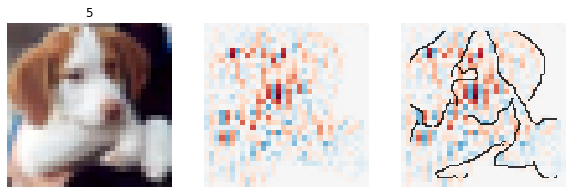

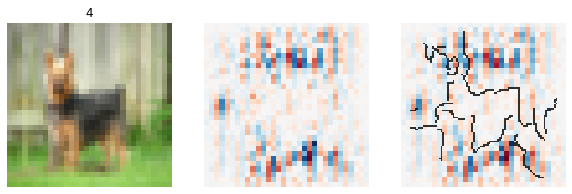

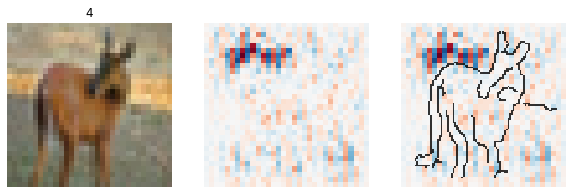

In [22]:
# ----- CIFAR -----
cifar_CNN = load_data('cifar')

new_layer = Dense(10,name='new_dense')
inp = cifar_CNN.layers[0].input
out = new_layer(cifar_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(cifar_CNN.layers[-1].get_weights())

img = [16,24,36]

with DeepExplain(session=K.get_session()) as de: 
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = cifar_x_data[img,:].reshape(-1,32,32,3).astype(np.float32)
    ys = np.eye(10)[np.array([5,4,4])]
    
    attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(cifar_CNN.predict((cifar_x_data[img[i],:].astype(np.float32)).reshape(1,32,32,3))))
    ax[0].axis('off')
    ax[0].imshow(cifar_x_data[img[i],:])
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i]/255,axis=ax[2],use_quantiles=True)
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/cifar_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


1.1554529666900635
1.5763967037200928
1.9713208675384521


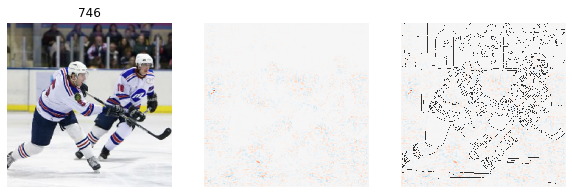

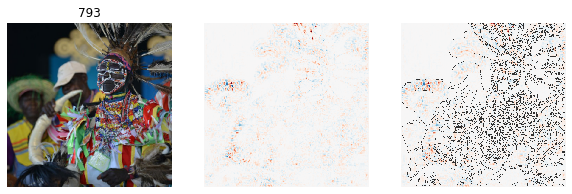

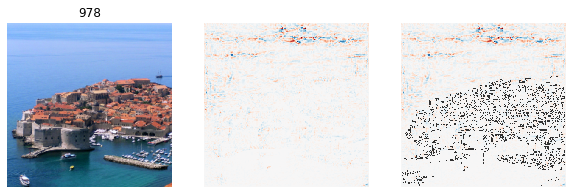

In [24]:
# ----- VGG -----
imagenet_VGG = load_data('imagenet')

new_layer = Dense(1000,name='new_dense')
inp = imagenet_VGG.layers[0].input
out = new_layer(imagenet_VGG.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(imagenet_VGG.layers[-1].get_weights())

img = [3,7,9]


with DeepExplain(session=K.get_session()) as de:  
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = imagenet_x_data[img,:].reshape(-1,224,224,3).astype(np.float32)
    ys = np.eye(1000)[np.array([746,793,978])]
    
    attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(imagenet_VGG.predict((imagenet_x_data[img[i],:].astype(np.float32)).reshape(1,224,224,3))))
    ax[0].axis('off')
    ax[0].imshow(imagenet_x_data[img[i],:]/255)
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i]/255,axis=ax[2])
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/imagenet_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

## ɛ-LRP

In [26]:
from scripts.images.deepexplain import DeepExplain
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

In [27]:
from skimage import feature, transform

def saliency_plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, use_quantiles=False):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        if use_quantiles:
            edges = feature.canny(in_image_upscaled,use_quantiles=True,high_threshold=0.9).astype(float)
        else: 
            edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

0.11287403106689453
0.1681818962097168
0.22333383560180664


/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


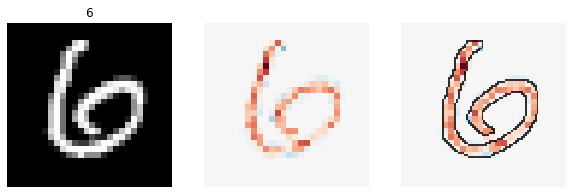

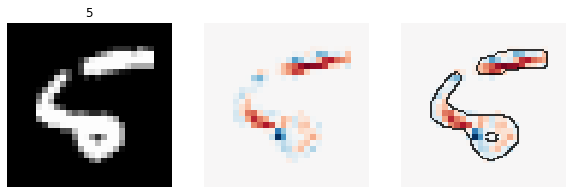

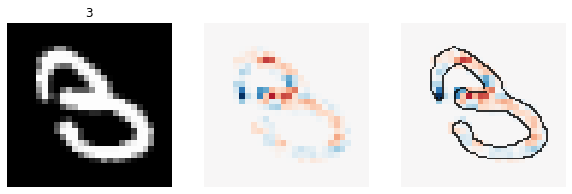

In [28]:
# ----- MNIST -----
MNIST_CNN = load_data('mnist')
new_layer = Dense(10,name='new_dense')
inp = MNIST_CNN.layers[0].input
out = new_layer(MNIST_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(MNIST_CNN.layers[-1].get_weights())

img = [11,8,18]

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model2.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    target_tensor = model2(input_tensor)
    
    xs = MNIST_x_data_test[img,:].reshape(-1,28,28,1).astype(np.float32)/255
    ys = np.eye(10)[np.array([6,5,3])]
    
    #attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(MNIST_CNN.predict((MNIST_x_data_test[img[i],:].astype(np.float32)/255).reshape(1,28,28,1))))
    ax[0].axis('off')
    ax[0].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i],axis=ax[2])
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/MNIST_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


0.14302492141723633
0.19996881484985352
0.2569098472595215


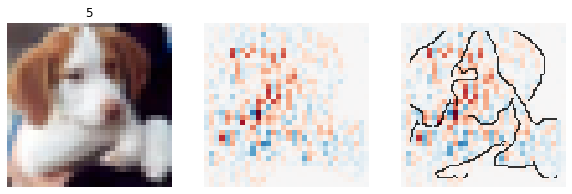

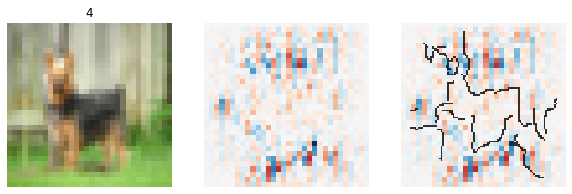

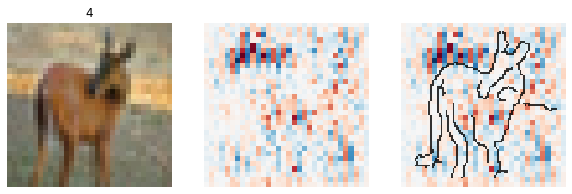

In [29]:
# ----- CIFAR -----
cifar_CNN = load_data('cifar')
new_layer = Dense(10,name='new_dense')
inp = cifar_CNN.layers[0].input
out = new_layer(cifar_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(cifar_CNN.layers[-1].get_weights())

img = [16,24,36]

with DeepExplain(session=K.get_session()) as de: 
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = cifar_x_data[img,:].reshape(-1,32,32,3).astype(np.float32)
    ys = np.eye(10)[np.array([5,4,4])]
    
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(cifar_CNN.predict((cifar_x_data[img[i],:].astype(np.float32)).reshape(1,32,32,3))))
    ax[0].axis('off')
    ax[0].imshow(cifar_x_data[img[i],:])
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i]/255,axis=ax[2],use_quantiles=True)
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/cifar_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
  # Remove the CWD from sys.path while we load stuff.


0.5092222690582275
1.0321290493011475
1.5040552616119385


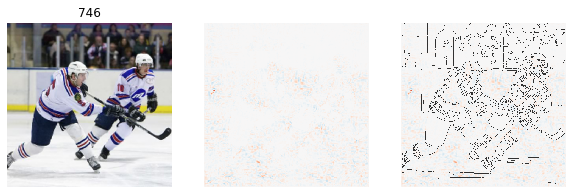

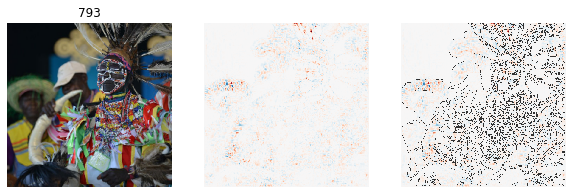

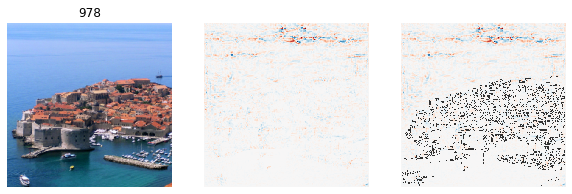

In [30]:
# ----- VGG -----
imagenet_VGG = load_data('imagenet')
new_layer = Dense(1000,name='new_dense')
inp = imagenet_VGG.layers[0].input
out = new_layer(imagenet_VGG.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(imagenet_VGG.layers[-1].get_weights())

img = [3,7,9]


with DeepExplain(session=K.get_session()) as de:  
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = imagenet_x_data[img,:].reshape(-1,224,224,3).astype(np.float32)
    ys = np.eye(1000)[np.array([746,793,978])]
    
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(1,3,figsize=(10,5))
    ax[0].set_title(np.argmax(imagenet_VGG.predict((imagenet_x_data[img[i],:].astype(np.float32)).reshape(1,224,224,3))))
    ax[0].axis('off')
    ax[0].imshow(imagenet_x_data[img[i],:]/255)
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i]/255,axis=ax[2])
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/imagenet_{img[i]}.png')
    #plt.close()
    print(time.time()-start)

## LIME

In [31]:
# Install from https://github.com/marcotcr/lime

In [7]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer(verbose = False)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.7848629951477051


  0%|          | 0/2000 [00:00<?, ?it/s]

0.7241249084472656


  0%|          | 0/2000 [00:00<?, ?it/s]

0.7508139610290527


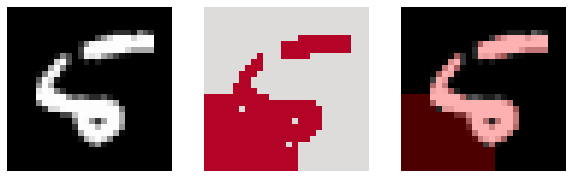

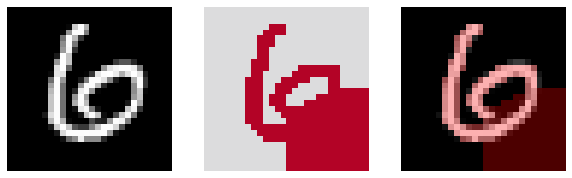

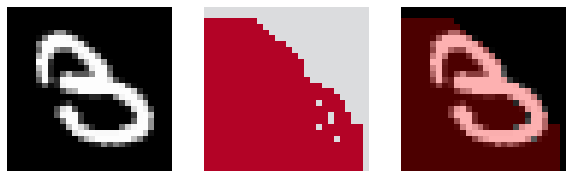

In [24]:
# -------- MNIST ---------
#LIME only support RGB image so we need to convert them
import time
from skimage.color import gray2rgb, rgb2gray, label2rgb
img1 = gray2rgb(MNIST_x_data_test[8:9,:].squeeze(0))
img2 = gray2rgb(MNIST_x_data_test[11:12,:].squeeze(0))
img3 = gray2rgb(MNIST_x_data_test[18:19,:].squeeze(0))

MNIST_CNN = load_data('mnist')

def LIME_wrapper(image):
    image = rgb2gray(image).reshape(-1,28,28,1)
    return MNIST_CNN.predict(image)

i = 0
for img in [img1,img2,img3]:
    F, ax = plt.subplots(1,3,figsize=(10,5))
    start = time.time()
    explanation = explainer.explain_instance(img, LIME_wrapper, top_labels=5, hide_color=0, num_samples=2000)
    print(time.time()-start)

    ax[0].imshow(img)
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(MNIST_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    ax[2].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax[2].axis('off')
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/LIME/MNIST_{MNIST_test_idx[i]}.png')
    i+=1
#plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

1.5246913433074951


  0%|          | 0/2000 [00:00<?, ?it/s]

1.6806912422180176


  0%|          | 0/2000 [00:00<?, ?it/s]

1.5369739532470703


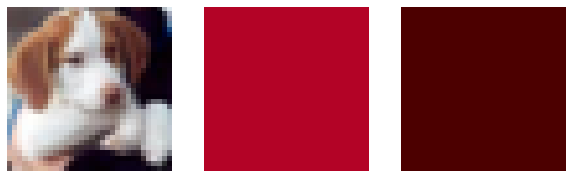

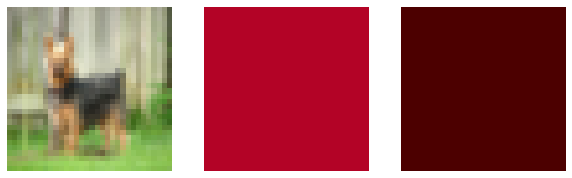

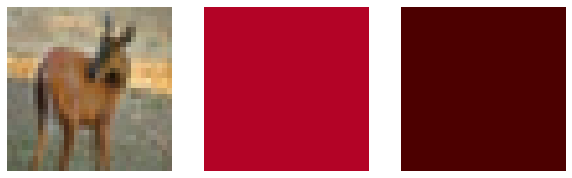

In [34]:
# -------- CIFAR ---------
cifar_CNN = load_data('cifar')

def LIME_wrapper(image):
    return cifar_CNN.predict(image/255)

i = 0
for img in CIFAR_test_idx:
    F, ax = plt.subplots(1,3,figsize=(10,5))
    start = time.time()
    explanation = explainer.explain_instance((cifar_x_data[img]*255).astype(int), LIME_wrapper, top_labels=5, hide_color=0, num_samples=2000)
    print(time.time()-start)

    ax[0].imshow(cifar_x_data[img])
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(CIFAR_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    ax[2].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax[2].axis('off')
    i+=1

  0%|          | 0/500 [00:00<?, ?it/s]

76.63868069648743


  0%|          | 0/500 [00:00<?, ?it/s]

82.45978093147278


  0%|          | 0/500 [00:00<?, ?it/s]

82.17234897613525


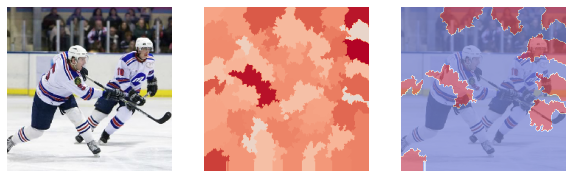

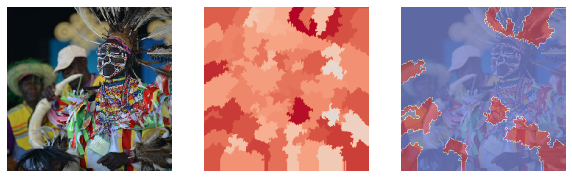

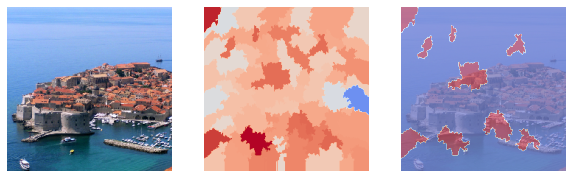

In [42]:
# -------- Imagenet ---------
from skimage.color import label2rgb
imagenet_VGG = load_data('imagenet')

i = 0
for img in IMAGENET_test_idx:
    F, ax = plt.subplots(1,3,figsize=(10,5))
    start = time.time()
    explanation = explainer.explain_instance(imagenet_x_data[img].astype(int), imagenet_VGG.predict, top_labels=5, hide_color=0, num_samples=500)
    print(time.time()-start)

    ax[0].imshow(imagenet_x_data[img].astype(int))
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(IMAGENET_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.001)
    ax[2].imshow(temp.astype(int),alpha=0.5)
    ax[2].imshow(mask,alpha=0.5,cmap='coolwarm')
    ax[2].axis('off')
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/LIME/IMAGENET_{img}.png')
    i+=1
#plt.close()

In [43]:
pred_indexes = np.argsort(imagenet_VGG.predict(imagenet_x_data[7:8,:]).ravel())[-3:][::-1]
print(pred_indexes)
print([imagenet_map[str(pred_indexes[i])][1] for i in range(len(pred_indexes))])
print(imagenet_VGG.predict(imagenet_x_data[7:8,:]).ravel()[pred_indexes])

[793 643 883]
['shower_cap', 'mask', 'vase']
[0.25550836 0.21546865 0.07227117]


In [ ]:
explanation = explainer.explain_instance(imagenet_x_data[img].astype(int), imagenet_VGG.predict, top_labels=3, num_samples=5000)

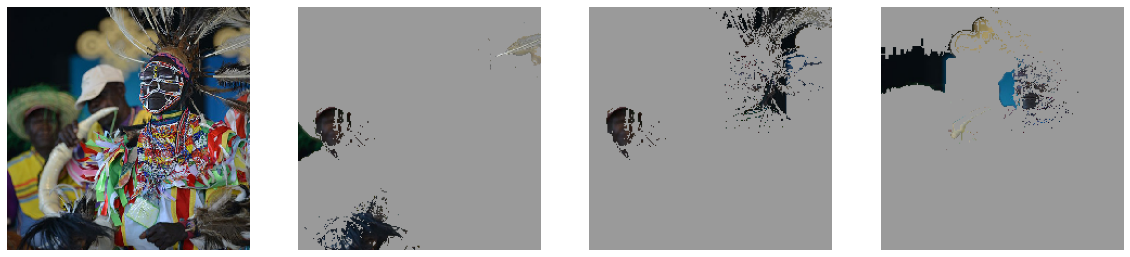

In [ ]:
from skimage.color import label2rgb

F, ax = plt.subplots(1,4,figsize=(20,15))
img = 7
ax[0].imshow(imagenet_x_data[7:8,:].astype(int).squeeze(0))
ax[0].axis('off')

for i in range(3):
    ind =  explanation.top_labels[i]
    #plot overlap
    temp, mask = explanation.get_image_and_mask(ind, positive_only=True, num_features=5, hide_rest=True, min_weight = 0.001)
    ax[i+1].imshow(imagenet_x_data[7:8].astype(int).squeeze(0)*np.repeat(mask[:,:,np.newaxis],3,axis=2).astype(int)+np.repeat((np.abs(mask-1)*154)[:,:,np.newaxis],3,axis=2))
    ax[i+1].axis('off')

## SmoothGrad

In [51]:
from scripts.images import saliency
# Code taken from https://github.com/PAIR-code/saliency

5 0.17779207229614258
6 0.05210757255554199
3 0.05249309539794922


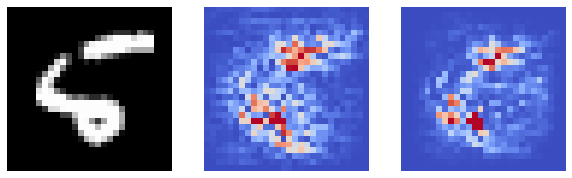

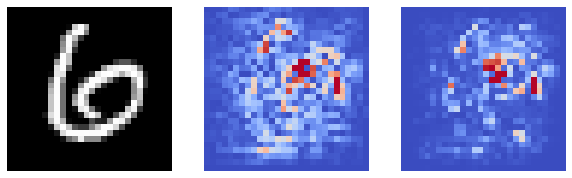

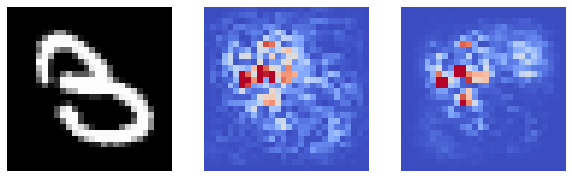

In [61]:
# --------- MNIST -----------
MNIST_CNN = load_data('mnist')

MNIST_test_idx = [8,11,18]
MNIST_y_hat = [5,6,3]

graph = K.get_session().graph

with graph.as_default():
    images = MNIST_CNN.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = MNIST_CNN.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

for idx in MNIST_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))
    
    # Load the image
    im = (MNIST_x_data_test[idx:idx+1,:]/255)

    # Show the image
    ax[0].imshow(im.reshape(28,28),cmap='gray')
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(28,28,1)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.reshape(28,28),cmap='gray',alpha=0.5)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.5)
    #ax[2].axis('off')
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/MNIST_{idx}_v2.png')

#plt.close()

5 0.28093814849853516
4 0.08564496040344238
4 0.0927438735961914


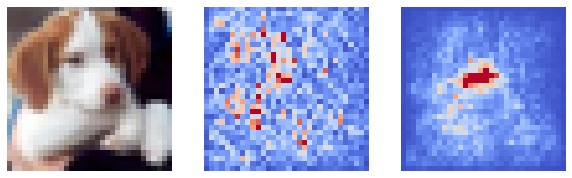

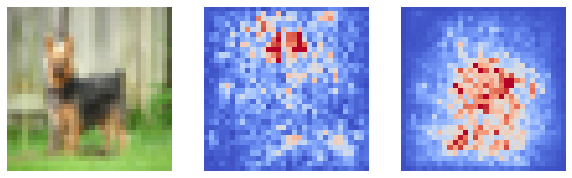

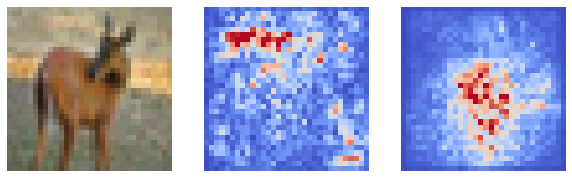

In [63]:
# --------- cifar -----------
cifar_CNN = load_data('cifar')
CIFAR_test_idx = [16,24,36]
CIFAR_y_hat = [5,4,4]

graph = K.get_session().graph

with graph.as_default():
    images = cifar_CNN.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = cifar_CNN.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

for idx in CIFAR_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))
    # Load the image
    im = (cifar_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(32,32,3)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(32,32,3), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(32,32,3), feed_dict = {neuron_selector: prediction_class})

    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.squeeze(0),cmap='gray',alpha=0.7)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.3)
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/CIFAR_{idx}_v2.png')

#plt.close()

746 15.003497838973999
793 14.471585988998413
978 14.599470853805542


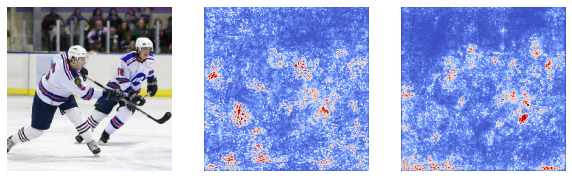

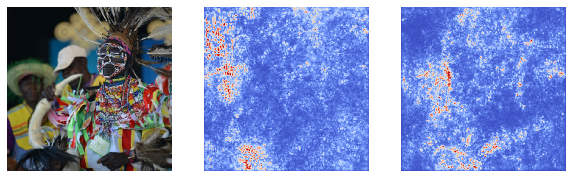

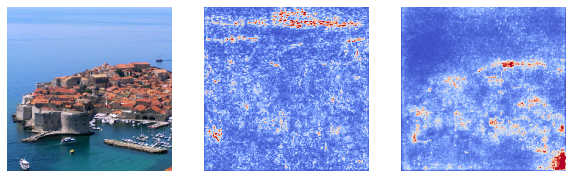

In [65]:
# --------- Imagenet -----------
imagenet_VGG = load_data('imagenet')
IMAGENET_test_idx = [3,7,9]
IMAGENET_y_hat = [746,793,978]

graph = K.get_session().graph

with graph.as_default():
    images = imagenet_VGG.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = imagenet_VGG.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

for idx in IMAGENET_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))
    # Load the image
    im = (imagenet_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0).astype(int))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(224,224,3)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(224,224,3), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(224,224,3), feed_dict = {neuron_selector: prediction_class})

    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.squeeze(0).astype(int),cmap='gray',alpha=0.7)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.3)
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/IMAGENET_{idx}_v2.png')

#plt.close()

## XRAI

In [66]:
from scripts.images import saliency
# Code taken from https://github.com/PAIR-code/saliency

5 0.9538118839263916
6 0.9700479507446289
3 0.8372759819030762


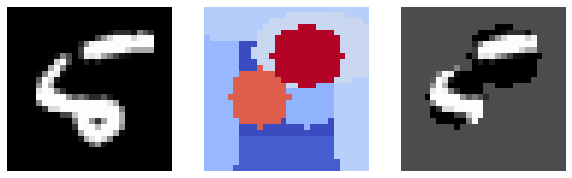

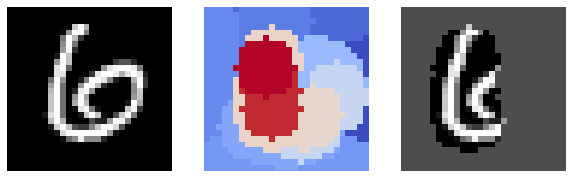

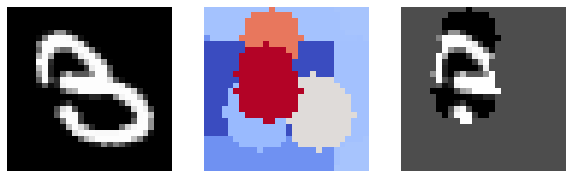

In [67]:
# --------- MNIST -----------
MNIST_CNN = load_data('mnist')

graph = K.get_session().graph

with graph.as_default():
    images = MNIST_CNN.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = MNIST_CNN.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

for idx in MNIST_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))

    # Load the image
    im = (MNIST_x_data_test[idx:idx+1,:]/255)

    # Show the image
    ax[0].imshow(im.reshape(28,28),cmap='gray')
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(28,28,1)]})

    # Compute the vanilla mask and the smoothed mask.
    #vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    xrai_attributions = xrai_object.GetMask(im.reshape(28,28,1), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)
    
    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask,cmap='gray')
    ax[2].axis('off')

5 1.3767023086547852
4 1.1962642669677734
4 1.2493770122528076


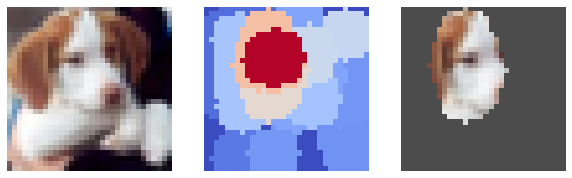

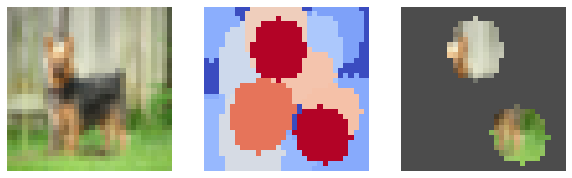

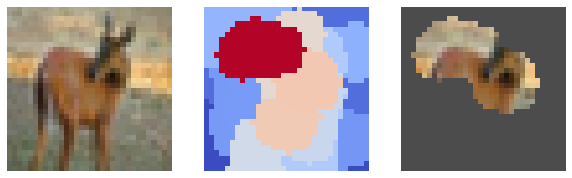

In [70]:
# --------- cifar -----------
cifar_CNN = load_data('cifar')

graph = K.get_session().graph

with graph.as_default():
    images = cifar_CNN.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = cifar_CNN.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

for idx in CIFAR_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))
    # Load the image
    im = (cifar_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(32,32,3)]})

    # Compute the vanilla mask and the smoothed mask.
    xrai_attributions = xrai_object.GetMask(im.reshape(32,32,3), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask,cmap='gray')
    ax[2].axis('off')

746 123.43605780601501
793 126.77066230773926
978 120.08551001548767


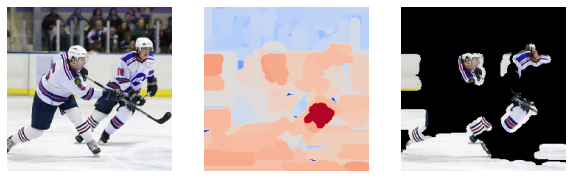

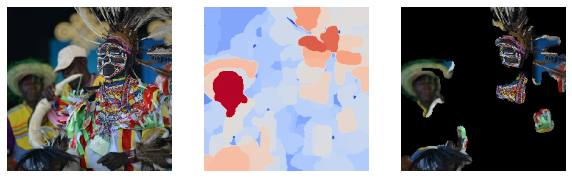

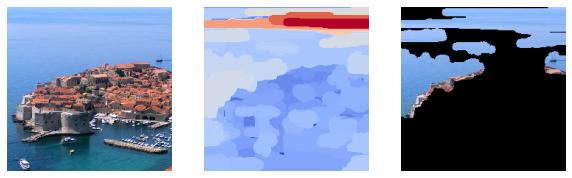

In [71]:
# --------- Imagenet -----------
imagenet_VGG = load_data('imagenet')

graph = K.get_session().graph

with graph.as_default():
    images = imagenet_VGG.inputs[0]
    sess = K.get_session()

    # Construct the scalar neuron tensor.
    logits = imagenet_VGG.get_output_at(-1)[0]
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits,axis=0)

import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

for idx in IMAGENET_test_idx:
    F,ax = plt.subplots(1,3,figsize=(10,5))
    # Load the image
    im = (imagenet_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0).astype(int))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(224,224,3)]})

    # Compute the vanilla mask and the smoothed mask.
    xrai_attributions = xrai_object.GetMask(im.reshape(224,224,3), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask.astype(int),cmap='gray')
    ax[2].axis('off')

## GradCAM and GradCAM++

In [7]:
#https://github.com/totti0223/gradcamplusplus
from scripts.images import gradcamutils

5 0.3332679271697998
6 0.3270888328552246
3 0.3442680835723877


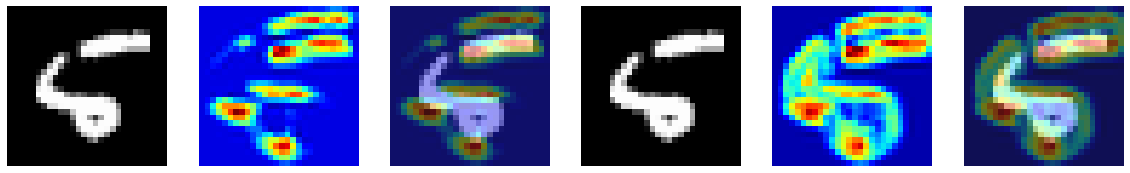

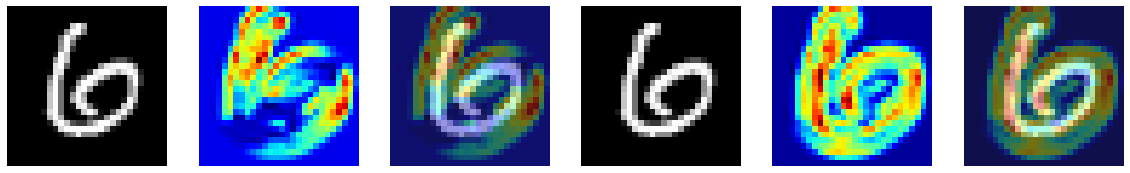

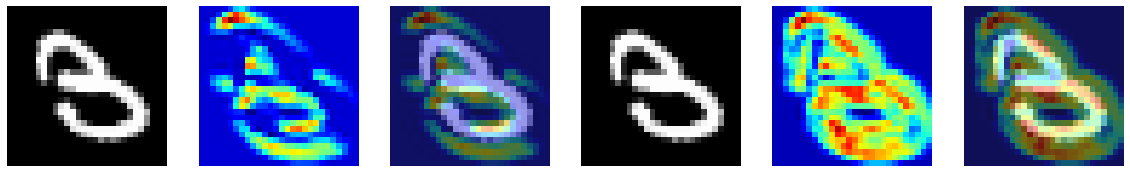

In [10]:
import time

# --------- MNIST -----------
MNIST_CNN = load_data('mnist')

for idx in MNIST_test_idx:
    fig, ax = plt.subplots(1,6,figsize=(20,5))
    img = MNIST_x_data_test[idx]
    predictions = MNIST_CNN.predict(img.reshape(1,28,28,1)/255)

    start = time.time()
    gradcam = gradcamutils.grad_cam(MNIST_CNN,img.reshape(1,28,28,1)/255,layer_name='conv2d_2',H=28,W=28)
    gradcamplus = gradcamutils.grad_cam_plus(MNIST_CNN,img.reshape(1,28,28,1)/255,layer_name='conv2d_2',H=28,W=28)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img, alpha=0.9, cmap='gray')
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img,cmap='gray')
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img, alpha=0.9, cmap='gray')
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')

5 0.32685089111328125
4 0.3460578918457031
4 0.3667948246002197


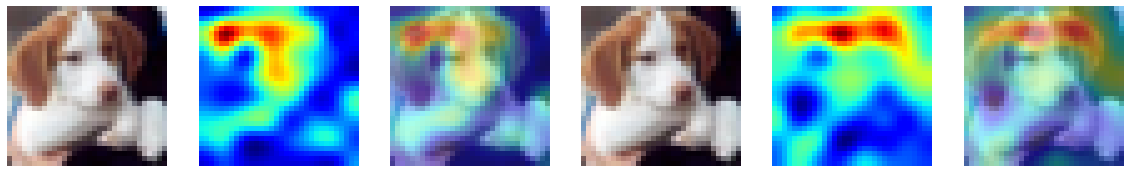

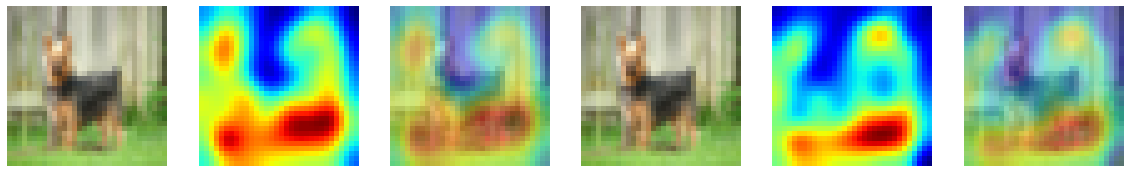

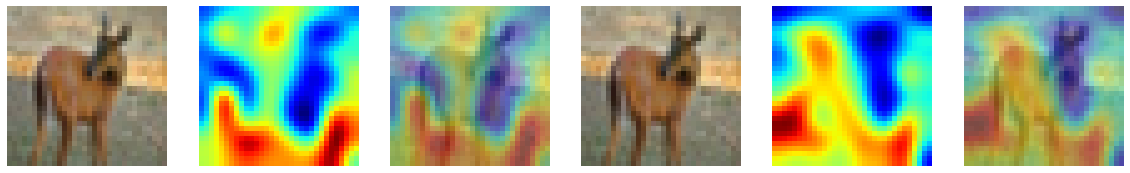

In [74]:
# --------- cifar -----------
cifar_CNN = load_data('cifar')

import time

for idx in CIFAR_test_idx:
    fig, ax = plt.subplots(1,6,figsize=(20,5))
    img = cifar_x_data[idx]
    predictions = cifar_CNN.predict(img.reshape(1,32,32,3))

    start = time.time()
    gradcam=gradcamutils.grad_cam(cifar_CNN,img.reshape(1,32,32,3),layer_name='conv2d_6',H=32,W=32)
    gradcamplus=gradcamutils.grad_cam_plus(cifar_CNN,img.reshape(1,32,32,3),layer_name='conv2d_6',H=32,W=32)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img)
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img, alpha=0.9)
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img)
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img, alpha=0.9)
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')

746 0.9958629608154297
793 1.0266411304473877
978 1.024139165878296


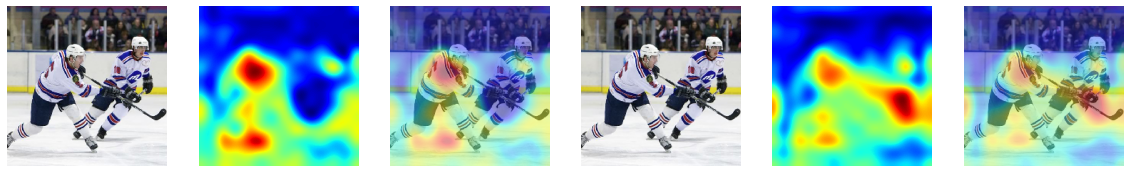

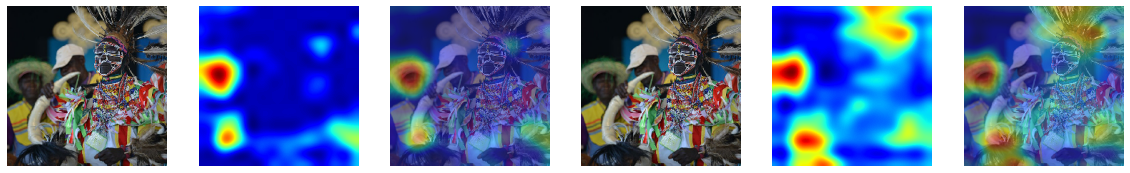

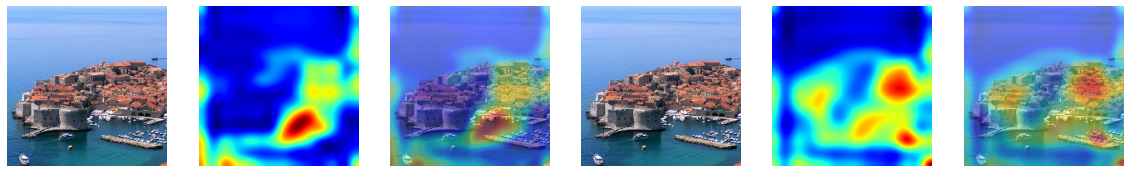

In [75]:
# --------- cifar -----------
imagenet_VGG = load_data('imagenet')

import time

for idx in IMAGENET_test_idx:
    fig, ax = plt.subplots(1,6,figsize=(20,5))
    img = imagenet_x_data[idx]
    predictions = imagenet_VGG.predict(img.reshape(1,224,224,3))

    start = time.time()
    gradcam=gradcamutils.grad_cam(imagenet_VGG,img.reshape(1,224,224,3),layer_name='block5_conv3',H=224,W=224)
    gradcamplus=gradcamutils.grad_cam_plus(imagenet_VGG,img.reshape(1,224,224,3),layer_name='block5_conv3',H=224,W=224)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img.astype(int))
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img.astype(int), alpha=0.9)
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img.astype(int))
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img.astype(int), alpha=0.9)
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')

## RISE

In [76]:
from skimage.transform import resize
from tqdm import tqdm
import time

In [79]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in range(0, N, batch_size):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    del preds
    sal = sal / N / p1
    return sal

2.041843891143799
1.9554939270019531
1.958899974822998


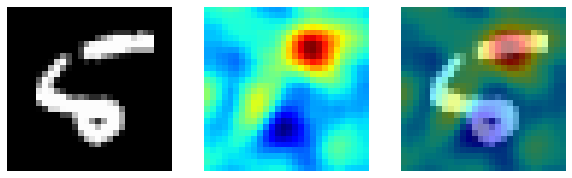

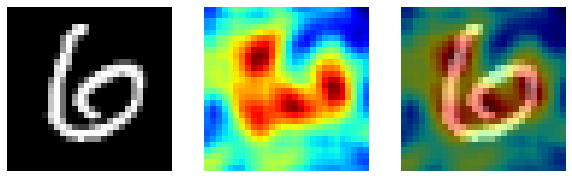

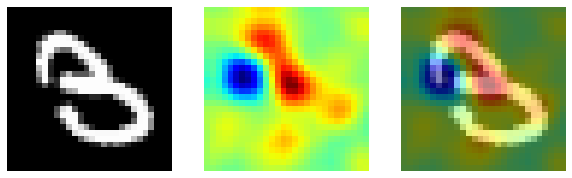

In [81]:
# --------- MNIST -----------
MNIST_CNN = load_data('mnist')

class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = MNIST_CNN
        self.input_size = (28, 28)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
i = 0

for idx in MNIST_test_idx:
    fig, ax = plt.subplots(1,3,figsize=(10,5))
    img = MNIST_x_data_test[idx]
    N = 2000
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(28,28,1)/255, masks)
    print(time.time()-start)
    
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[MNIST_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img,cmap='gray')
    ax[2].imshow(sal[MNIST_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1

2.9601430892944336
3.0608949661254883
3.0543429851531982


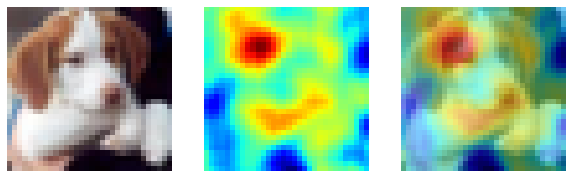

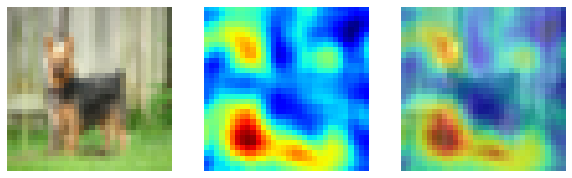

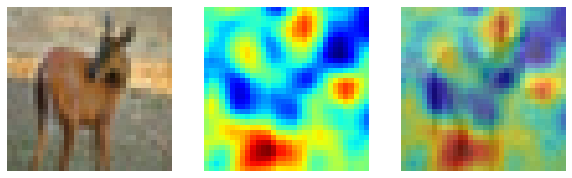

In [82]:
# --------- cifar -----------
cifar_CNN = load_data('cifar')

class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = cifar_CNN
        self.input_size = (32, 32)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
i = 0

for idx in CIFAR_test_idx:
    fig, ax = plt.subplots(1,3,figsize=(10,5))
    img = cifar_x_data[idx]
    N = 2000
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(32,32,3), masks)
    print(time.time()-start)
    
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[CIFAR_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img,cmap='gray')
    ax[2].imshow(sal[CIFAR_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1

75.99447965621948
67.99412322044373
68.30063796043396


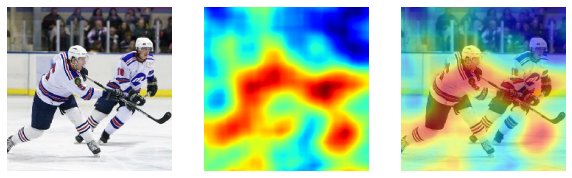

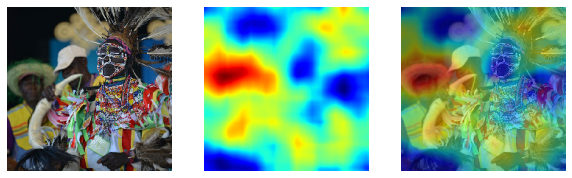

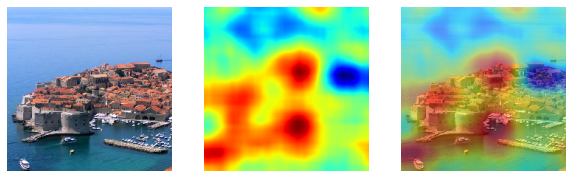

In [85]:
# --------- imagenet -----------
imagenet_VGG = load_data('imagenet')

class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = imagenet_VGG
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
i = 0

for idx in IMAGENET_test_idx:
    fig, ax = plt.subplots(1,3,figsize=(10,5))
    img = imagenet_x_data[idx]
    N = 500
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(224,224,3), masks)
    print(time.time()-start)
    
    ax[0].imshow(img.astype(int),cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[IMAGENET_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img.astype(int),cmap='gray')
    ax[2].imshow(sal[IMAGENET_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1

# Concept Attirbution

## TCAV

In [15]:
from scripts.images.tcav import activation_generator as act_gen
from scripts.images.tcav import cav
from scripts.images.tcav import model
from scripts.images.tcav import tcav
from scripts.images.tcav import utils
from scripts.images.tcav import utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

In [16]:
# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = './scripts/images/tcav/'
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ 'activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + 'cavs/'
# where the images live. 
source_dir = './scripts/images/tcav/test_images/'
bottlenecks = [ 'mixed4c']  # @param 
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'puck'  
concepts = ["ice","hockey_player","fans"]   

In [17]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = "./scripts/images/tcav/inception5h/tensorflow_inception_graph.pb"
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...

LABEL_PATH = "./scripts/images/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

In [18]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

In [10]:
tf.logging.set_verbosity(10)
num_random_exp = 10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed4c ['ice', 'random500_0'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_1'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_2'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_3'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_4'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_5'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_6'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_7'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_8'] puck 0.1
INFO:tensorflow:mixed4c ['ice', 'random500_9'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_0'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_1'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_2'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_3'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_4'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'random500_5'] puck 0.1
INFO:tensorflow:mixed4c ['hockey_player', 'r

Class = puck
  Concept = ice
    Bottleneck = mixed4c. TCAV Score = 0.76 (+- 0.07), random was 0.48 (+- 0.16). p-val = 0.000 (significant)
  Concept = hockey_player
    Bottleneck = mixed4c. TCAV Score = 0.64 (+- 0.07), random was 0.48 (+- 0.16). p-val = 0.003 (significant)
  Concept = fans
    Bottleneck = mixed4c. TCAV Score = 0.33 (+- 0.09), random was 0.48 (+- 0.16). p-val = 0.004 (significant)
{'mixed4c': {'bn_vals': [0.7606060606060606, 0.6424242424242425, 0.3303030303030303], 'bn_stds': [0.0696969696969697, 0.07397912494384064, 0.0933510412166628], 'significant': [True, True, True]}}


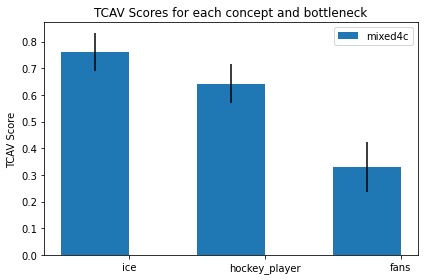

In [11]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

# Prototypes and Counterfactuals

## MMD-Critic

In [8]:
from sklearn.datasets import dump_svmlight_file
from skimage.color import rgb2gray
dump_svmlight_file(cifar_x_data[:8000].reshape(-1,32*32*3), cifar_y_data[:8000].reshape(-1,),'./scripts/images/mmdcritic/data/usps',zero_based=False)
dump_svmlight_file(cifar_x_data[8000:].reshape(-1,32*32*3), cifar_y_data[8000:].reshape(-1,),'./scripts/images/mmdcritic/data/usps.t',zero_based=False)

In [14]:
import time
start = time.time()
!python ./scripts/images/mmdcritic/run.py --data_directory ./scripts/images/mmdcritic/data --output_directory ./scripts/images/mmdcritic/output
print(time.time()-start)

Running Kernel type : global 
0 8
1 12
2 10
3 13
4 16
5 9
6 9
7 7
8 5
9 0
number of images being printed 100
counter 1 
 begin 0, end 40
counter 2 
 begin 40, end 80
counter 3 
 begin 80, end 100
0 11
1 9
2 13
3 6
4 12
5 10
6 9
7 9
8 5
9 0
number of images being printed 100
counter 1 
 begin 0, end 40
counter 2 
 begin 40, end 80
counter 3 
 begin 80, end 100
building model using 10 points 
classifying 2000 points 
m=10 error=0.836500
building model using 30 points 
classifying 2000 points 
m=30 error=0.813500
building model using 50 points 
classifying 2000 points 
m=50 error=0.808500
building model using 70 points 
classifying 2000 points 
m=70 error=0.795500
building model using 80 points 
classifying 2000 points 
m=80 error=0.794000
building model using 90 points 
classifying 2000 points 
m=90 error=0.792000
building model using 100 points 
classifying 2000 points 
m=100 error=0.790500
...done
85.42323613166809


## Guided Prototypes

In [17]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from keras.models import Model, load_model
from keras.utils import to_categorical


import matplotlib.pyplot as plt
import numpy as np
import os
from time import time

from scripts.images.alibi.explainers import CounterFactualProto

MNIST_CNN = load_data('mnist')
MNIST_CNN.trainable=False

(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = keras.datasets.mnist.load_data()
MNIST_x_data_train = MNIST_x_data_train.reshape(-1,28,28,1)/255
MNIST_x_data_test = MNIST_x_data_test.reshape(-1,28,28,1)/255

In [19]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

ae, enc, dec = ae_model()
ae.fit(MNIST_x_data_train, MNIST_x_data_train, batch_size=128, epochs=4, validation_data=(MNIST_x_data_test, MNIST_x_data_test), verbose=2)

# Save for later if you want
#ae.save('mnist_ae.h5', save_format='h5')
#enc.save('mnist_enc.h5', save_format='h5')
# Later Loading
#ae = load_model('mnist_ae.h5')
#enc = load_model('mnist_enc.h5', compile=False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
 - 59s - loss: 0.0114 - val_loss: 0.0026
Epoch 2/4
 - 56s - loss: 0.0022 - val_loss: 0.0019
Epoch 3/4
 - 59s - loss: 0.0018 - val_loss: 0.0017
Epoch 4/4
 - 58s - loss: 0.0017 - val_loss: 0.0016


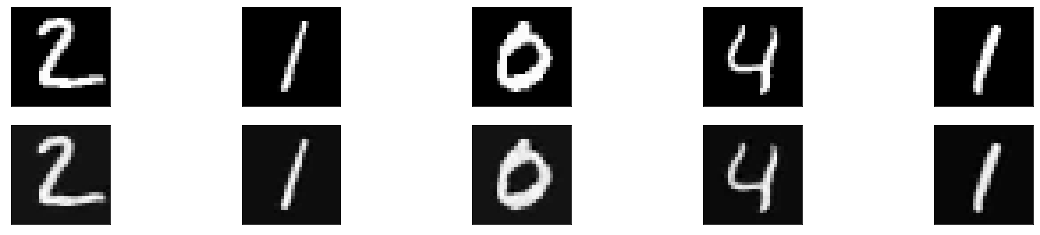

In [21]:
decoded_imgs = ae.predict(MNIST_x_data_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(MNIST_x_data_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
shape = (1,) + MNIST_x_data_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (MNIST_x_data_train.min(),MNIST_x_data_train.max())

label:  5
predicted class:  5
increasing order of predictions:  [5 6 8 9 0 4 3 2 1 7]


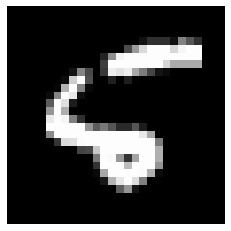

In [23]:
X = MNIST_x_data_test[8].reshape((1,) + MNIST_x_data_test[0].shape)
plt.imshow(X.reshape(28, 28),cmap='gray');
print('label: ',MNIST_y_data_test[8])
print('predicted class: ', np.argmax(MNIST_CNN.predict(MNIST_x_data_test[8:9,:])))
print('increasing order of predictions: ', np.flip(np.argsort(MNIST_CNN.predict_proba(MNIST_x_data_test[8:9,:])).ravel()))
plt.axis('off');

In [24]:
# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(MNIST_CNN, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(MNIST_x_data_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Time to find prototypes each class: 23.710 sec
Explanation took 8.436 sec


Counterfactual prediction: 9
Closest prototype class: 4


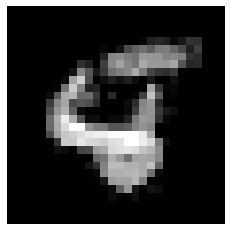

In [25]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28),cmap='gray');
plt.axis('off');

Counterfactual prediction: 6
Closest prototype class: 4


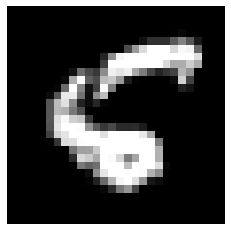

In [27]:
# We can also variate the number of NN used for producing the counterfactuals
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 6
Closest prototype class: 4


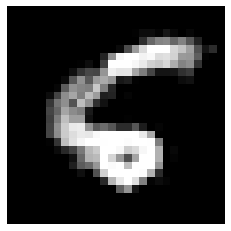

In [28]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

In [29]:
# specify the class we want for the counterfactual
explanation_1 = cf.explain(X, k=5, k_type='mean', target_class=[6])
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[8])
proto_2 = explanation_2.id_proto
explanation_3 = cf.explain(X, k=5, k_type='mean', target_class=[9])
proto_3 = explanation_3.id_proto

Counterfactual prediction: 6
Closest prototype class: 6


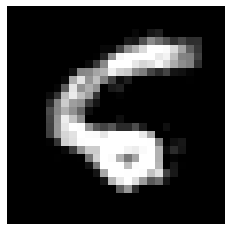

In [30]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 8
Closest prototype class: 8


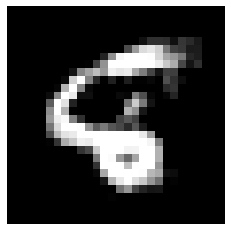

In [31]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 9
Closest prototype class: 9


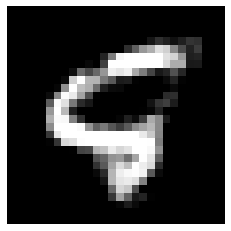

In [32]:
print('Counterfactual prediction: {}'.format(explanation_3.cf['class']))
print(f'Closest prototype class: {proto_3}')
plt.imshow(explanation_3.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

## CEM

In [35]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from scripts.images.alibi.explainers import CEM

MNIST_CNN = load_data('mnist')
MNIST_CNN.trainable=False

(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = tf.keras.datasets.mnist.load_data()
MNIST_x_data_train = MNIST_x_data_train.reshape(-1,28,28,1)/255
MNIST_x_data_test = MNIST_x_data_test.reshape(-1,28,28,1)/255

In [37]:
import time
start = time.time()

def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

ae, enc, dec = ae_model()
ae.fit(MNIST_x_data_train, MNIST_x_data_train, batch_size=128, epochs=4, validation_data=(MNIST_x_data_test, MNIST_x_data_test), verbose=2)

# Save for Later
#ae.save('mnist_ae.h5', save_format='h5')
#enc.save('mnist_enc.h5', save_format='h5')
# Later Loading
#ae = ae.load_model('mnist_ae.h5')
#enc = enc.load_model('mnist_enc.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 - 63s - loss: 0.0095 - val_loss: 0.0025
Epoch 2/4
60000/60000 - 60s - loss: 0.0021 - val_loss: 0.0018
Epoch 3/4
60000/60000 - 61s - loss: 0.0017 - val_loss: 0.0016
Epoch 4/4
60000/60000 - 61s - loss: 0.0016 - val_loss: 0.0015


label:  5
predicted class:  5
increasing order of predictions:  [5 6 8 9 0 4 3 2 1 7]


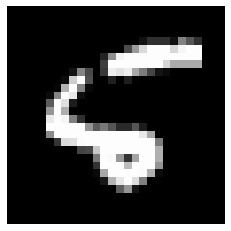

In [38]:
X = MNIST_x_data_test[8].reshape((1,) + MNIST_x_data_test[0].shape)
plt.imshow(X.reshape(28, 28),cmap='gray');
print('label: ',MNIST_y_data_test[8])
print('predicted class: ', np.argmax(MNIST_CNN.predict(MNIST_x_data_test[8:9,:])))
print('increasing order of predictions: ', np.flip(np.argsort(MNIST_CNN.predict_proba(MNIST_x_data_test[8:9,:])).ravel()))
plt.axis('off');

In [39]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + MNIST_x_data_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (MNIST_x_data_train.min(),MNIST_x_data_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [40]:
# initialize CEM explainer and explain instance
cem = CEM(MNIST_CNN, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)
print(time.time()-start)

316.5411992073059


Pertinent negative prediction: 6


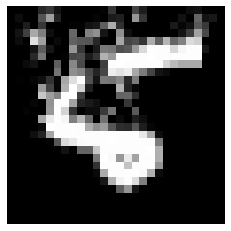

In [41]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN.reshape(28, 28),cmap='gray')
plt.axis('off');

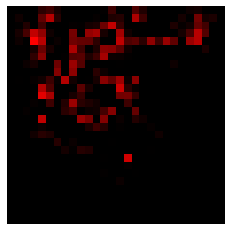

In [42]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)]  # R -> G -> B
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=150)
plt.imshow(explanation.PN.reshape(28, 28)-X.reshape(28,28),cmap=cm)
plt.axis('off');

In [43]:
mode = 'PP'
# initialize CEM explainer and explain instance
cem = CEM(MNIST_CNN, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


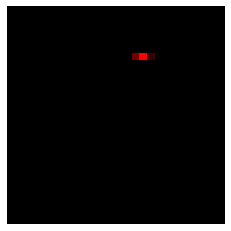

In [44]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)]  # R -> G -> B
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28),cmap=cm,alpha=1)
plt.axis('off');